# 零基础入门数据挖掘-Baseline

## Baseline-v1.0 版

Tip:这是一个最初始baseline版本,抛砖引玉,为大家提供一个基本Baseline和一个竞赛流程的基本介绍，欢迎大家多多交流。

**赛题：零基础入门数据挖掘 - 二手车交易价格预测**

地址：https://tianchi.aliyun.com/competition/entrance/231784/introduction?spm=5176.12281957.1004.1.38b02448ausjSX


### Step 1:导入函数工具箱

In [1]:
## 基础工具
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import jn
from IPython.display import display, clear_output
import time
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## 模型预测的
import lightgbm as lgb
import xgboost as xgb
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor

## 参数搜索和评价的
from sklearn.model_selection import GridSearchCV,cross_val_score,StratifiedKFold,train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

### Step 2:数据探索

In [2]:
## 通过Pandas对于数据进行读取 (pandas是一个很友好的数据读取函数库)
# Train_data = pd.read_csv('used_car_train_20200313.csv', sep=' ')
# TestA_data = pd.read_csv('used_car_testB_20200421.csv', sep=' ')

data = pd.read_csv('data_for_lr.csv', sep=',')
Train_data = data[np.isnan(data['price']).values == False]
TestA_data = data[np.isnan(data['price'])]

## 输出数据的大小信息
print('Train data shape:',Train_data.shape)
print('TestA data shape:',TestA_data.shape)

Train data shape: (149037, 370)
TestA data shape: (50000, 370)


#### 1) 数据简要浏览

In [3]:
## 通过.head() 简要浏览读取数据的形式
Train_data['price'].tail()

149032    5900.0
149033    9500.0
149034    7500.0
149035    4999.0
149036    4700.0
Name: price, dtype: float64

#### 2) 数据信息查看

In [4]:
## 通过 .info() 简要可以看到对应一些数据列名，以及NAN缺失信息
Train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149037 entries, 0 to 149036
Columns: 370 entries, SaleID to power_bin_29.0
dtypes: float64(27), int64(343)
memory usage: 421.9 MB


In [5]:
## 通过 .columns 查看列名
Train_data.columns

Index(['SaleID', 'name', 'power', 'kilometer', 'seller', 'offerType', 'price',
       'v_0', 'v_1', 'v_2',
       ...
       'power_bin_20.0', 'power_bin_21.0', 'power_bin_22.0', 'power_bin_23.0',
       'power_bin_24.0', 'power_bin_25.0', 'power_bin_26.0', 'power_bin_27.0',
       'power_bin_28.0', 'power_bin_29.0'],
      dtype='object', length=370)

#### 3) 数据统计信息浏览

In [6]:
## 通过 .describe() 可以查看数值特征列的一些统计信息
Train_data.describe()

,SaleID,name,power,kilometer,seller,offerType,price,v_0,v_1,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14,train,used_time,city,brand_amount,brand_price_max,brand_price_median,brand_price_min,brand_price_sum,brand_price_std,brand_price_average,model_0.0,model_1.0,model_2.0,model_3.0,model_4.0,model_5.0,model_6.0,model_7.0,model_8.0,model_9.0,model_10.0,model_11.0,model_12.0,model_13.0,model_14.0,model_15.0,model_16.0,model_17.0,model_18.0,model_19.0,model_20.0,model_21.0,model_22.0,model_23.0,model_24.0,model_25.0,model_26.0,model_27.0,model_28.0,model_29.0,model_30.0,model_31.0,model_32.0,model_33.0,model_34.0,model_35.0,model_36.0,model_37.0,model_38.0,model_39.0,model_40.0,model_41.0,model_42.0,model_43.0,model_44.0,model_45.0,model_46.0,model_47.0,model_48.0,model_49.0,model_50.0,model_51.0,model_52.0,model_53.0,model_54.0,model_55.0,model_56.0,model_57.0,model_58.0,model_59.0,model_60.0,model_61.0,model_62.0,model_63.0,model_64.0,model_65.0,model_66.0,model_67.0,model_68.0,model_69.0,model_70.0,model_71.0,model_72.0,model_73.0,model_74.0,model_75.0,model_76.0,model_77.0,model_78.0,model_79.0,model_80.0,model_81.0,model_82.0,model_83.0,model_84.0,model_85.0,model_86.0,model_87.0,model_88.0,model_89.0,model_90.0,model_91.0,model_92.0,model_93.0,model_94.0,model_95.0,model_96.0,model_97.0,model_98.0,model_99.0,model_100.0,model_101.0,model_102.0,model_103.0,model_104.0,model_105.0,model_106.0,model_107.0,model_108.0,model_109.0,model_110.0,model_111.0,model_112.0,model_113.0,model_114.0,model_115.0,model_116.0,model_117.0,model_118.0,model_119.0,model_120.0,model_121.0,model_122.0,model_123.0,model_124.0,model_125.0,model_126.0,model_127.0,model_128.0,model_129.0,model_130.0,model_131.0,model_132.0,model_133.0,model_134.0,model_135.0,model_136.0,model_137.0,model_138.0,model_139.0,model_140.0,model_141.0,model_142.0,model_143.0,model_144.0,model_145.0,model_146.0,model_147.0,model_148.0,model_149.0,model_150.0,model_151.0,model_152.0,model_153.0,model_154.0,model_155.0,model_156.0,model_157.0,model_158.0,model_159.0,model_160.0,model_161.0,model_162.0,model_163.0,model_164.0,model_165.0,model_166.0,model_167.0,model_168.0,model_169.0,model_170.0,model_171.0,model_172.0,model_173.0,model_174.0,model_175.0,model_176.0,model_177.0,model_178.0,model_179.0,model_180.0,model_181.0,model_182.0,model_183.0,model_184.0,model_185.0,model_186.0,model_187.0,model_188.0,model_189.0,model_190.0,model_191.0,model_192.0,model_193.0,model_194.0,model_195.0,model_196.0,model_197.0,model_198.0,model_199.0,model_200.0,model_201.0,model_202.0,model_203.0,model_204.0,model_205.0,model_206.0,model_207.0,model_208.0,model_209.0,model_210.0,model_211.0,model_212.0,model_213.0,model_214.0,model_215.0,model_216.0,model_217.0,model_218.0,model_219.0,model_220.0,model_221.0,model_222.0,model_223.0,model_224.0,model_225.0,model_226.0,model_227.0,model_228.0,model_229.0,model_230.0,model_231.0,model_232.0,model_233.0,model_234.0,model_235.0,model_236.0,model_237.0,model_238.0,model_239.0,model_240.0,model_241.0,model_242.0,model_243.0,model_244.0,model_245.0,model_246.0,model_247.0,brand_0,brand_1,brand_2,brand_3,brand_4,brand_5,brand_6,brand_7,brand_8,brand_9,brand_10,brand_11,brand_12,brand_13,brand_14,brand_15,brand_16,brand_17,brand_18,brand_19,brand_20,brand_21,brand_22,brand_23,brand_24,brand_25,brand_26,brand_27,brand_28,brand_29,brand_30,brand_31,brand_32,brand_33,brand_34,brand_35,brand_36,brand_37,brand_38,brand_39,bodyType_0.0,bodyType_1.0,bodyType_2.0,bodyType_3.0,bodyType_4.0,bodyType_5.0,bodyType_6.0,bodyType_7.0,fuelType_0.0,fuelType_1.0,fuelType_2.0,fuelType_3.0,fuelType_4.0,fuelType_5.0,fuelType_6.0,gearbox_0.0,gearbox_1.0,notRepairedDamage_-,notRepairedDamage_0.0,notRepairedDamage_1.0,power_bin_0.0,power_bin_1.0,power_bin_2.0,power_bin_3.0,power_bin_4.0,power_bin_5.0,power_bin_6.0,power_bin_7.0,power_bin_8.0,power_bin_9.0,power_bin_10.0,power_bin_11.0,power_bin_12.0,power_bin_13.0,power_bin_14.0,power_bin_15.0,power_bin_16.0,po

In [7]:
TestA_data.describe()

,SaleID,name,power,kilometer,seller,offerType,price,v_0,v_1,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14,train,used_time,city,brand_amount,brand_price_max,brand_price_median,brand_price_min,brand_price_sum,brand_price_std,brand_price_average,model_0.0,model_1.0,model_2.0,model_3.0,model_4.0,model_5.0,model_6.0,model_7.0,model_8.0,model_9.0,model_10.0,model_11.0,model_12.0,model_13.0,model_14.0,model_15.0,model_16.0,model_17.0,model_18.0,model_19.0,model_20.0,model_21.0,model_22.0,model_23.0,model_24.0,model_25.0,model_26.0,model_27.0,model_28.0,model_29.0,model_30.0,model_31.0,model_32.0,model_33.0,model_34.0,model_35.0,model_36.0,model_37.0,model_38.0,model_39.0,model_40.0,model_41.0,model_42.0,model_43.0,model_44.0,model_45.0,model_46.0,model_47.0,model_48.0,model_49.0,model_50.0,model_51.0,model_52.0,model_53.0,model_54.0,model_55.0,model_56.0,model_57.0,model_58.0,model_59.0,model_60.0,model_61.0,model_62.0,model_63.0,model_64.0,model_65.0,model_66.0,model_67.0,model_68.0,model_69.0,model_70.0,model_71.0,model_72.0,model_73.0,model_74.0,model_75.0,model_76.0,model_77.0,model_78.0,model_79.0,model_80.0,model_81.0,model_82.0,model_83.0,model_84.0,model_85.0,model_86.0,model_87.0,model_88.0,model_89.0,model_90.0,model_91.0,model_92.0,model_93.0,model_94.0,model_95.0,model_96.0,model_97.0,model_98.0,model_99.0,model_100.0,model_101.0,model_102.0,model_103.0,model_104.0,model_105.0,model_106.0,model_107.0,model_108.0,model_109.0,model_110.0,model_111.0,model_112.0,model_113.0,model_114.0,model_115.0,model_116.0,model_117.0,model_118.0,model_119.0,model_120.0,model_121.0,model_122.0,model_123.0,model_124.0,model_125.0,model_126.0,model_127.0,model_128.0,model_129.0,model_130.0,model_131.0,model_132.0,model_133.0,model_134.0,model_135.0,model_136.0,model_137.0,model_138.0,model_139.0,model_140.0,model_141.0,model_142.0,model_143.0,model_144.0,model_145.0,model_146.0,model_147.0,model_148.0,model_149.0,model_150.0,model_151.0,model_152.0,model_153.0,model_154.0,model_155.0,model_156.0,model_157.0,model_158.0,model_159.0,model_160.0,model_161.0,model_162.0,model_163.0,model_164.0,model_165.0,model_166.0,model_167.0,model_168.0,model_169.0,model_170.0,model_171.0,model_172.0,model_173.0,model_174.0,model_175.0,model_176.0,model_177.0,model_178.0,model_179.0,model_180.0,model_181.0,model_182.0,model_183.0,model_184.0,model_185.0,model_186.0,model_187.0,model_188.0,model_189.0,model_190.0,model_191.0,model_192.0,model_193.0,model_194.0,model_195.0,model_196.0,model_197.0,model_198.0,model_199.0,model_200.0,model_201.0,model_202.0,model_203.0,model_204.0,model_205.0,model_206.0,model_207.0,model_208.0,model_209.0,model_210.0,model_211.0,model_212.0,model_213.0,model_214.0,model_215.0,model_216.0,model_217.0,model_218.0,model_219.0,model_220.0,model_221.0,model_222.0,model_223.0,model_224.0,model_225.0,model_226.0,model_227.0,model_228.0,model_229.0,model_230.0,model_231.0,model_232.0,model_233.0,model_234.0,model_235.0,model_236.0,model_237.0,model_238.0,model_239.0,model_240.0,model_241.0,model_242.0,model_243.0,model_244.0,model_245.0,model_246.0,model_247.0,brand_0,brand_1,brand_2,brand_3,brand_4,brand_5,brand_6,brand_7,brand_8,brand_9,brand_10,brand_11,brand_12,brand_13,brand_14,brand_15,brand_16,brand_17,brand_18,brand_19,brand_20,brand_21,brand_22,brand_23,brand_24,brand_25,brand_26,brand_27,brand_28,brand_29,brand_30,brand_31,brand_32,brand_33,brand_34,brand_35,brand_36,brand_37,brand_38,brand_39,bodyType_0.0,bodyType_1.0,bodyType_2.0,bodyType_3.0,bodyType_4.0,bodyType_5.0,bodyType_6.0,bodyType_7.0,fuelType_0.0,fuelType_1.0,fuelType_2.0,fuelType_3.0,fuelType_4.0,fuelType_5.0,fuelType_6.0,gearbox_0.0,gearbox_1.0,notRepairedDamage_-,notRepairedDamage_0.0,notRepairedDamage_1.0,power_bin_0.0,power_bin_1.0,power_bin_2.0,power_bin_3.0,power_bin_4.0,power_bin_5.0,power_bin_6.0,power_bin_7.0,power_bin_8.0,power_bin_9.0,power_bin_10.0,power_bin_11.0,power_bin_12.0,power_bin_13.0,power_bin_14.0,power_bin_15.0,power_bin_16.0,po

### Step 3:特征工程

#### 1) 删除无用特征

In [8]:
Train_data.shape

(149037, 370)

In [9]:
def delete_useless_features(data):
    del data['v_1']
    del data['v_2']
    del data['v_6']
    del data['v_7']
    del data['v_13']
    del data['v_14']
    return data

# Train_data = delete_useless_features(Train_data)

#### 1) 提取数值类型和类别特征列名

In [10]:
numerical_cols = Train_data.select_dtypes(exclude = 'object').columns
print(numerical_cols)
categorical_cols = Train_data.select_dtypes(include = 'object').columns
print(categorical_cols)

Index(['SaleID', 'name', 'power', 'kilometer', 'seller', 'offerType', 'price',
       'v_0', 'v_1', 'v_2',
       ...
       'power_bin_20.0', 'power_bin_21.0', 'power_bin_22.0', 'power_bin_23.0',
       'power_bin_24.0', 'power_bin_25.0', 'power_bin_26.0', 'power_bin_27.0',
       'power_bin_28.0', 'power_bin_29.0'],
      dtype='object', length=370)
Index([], dtype='object')


#### 2) 缺失值处理

In [11]:
Train_data.shape

(149037, 370)

In [12]:
def missing_data_deal(data):
    # 删除
#     data = data.dropna(subset=['model'])

    # 均值填充
#     data['bodyType'] = data['bodyType'].fillna(data['bodyType'].mean())
#     data['fuelType'] = data['fuelType'].fillna(data['fuelType'].mean())
#     data['gearbox'] = data['gearbox'].fillna(data['gearbox'].mean())
    
    #用0填充缺失值
    data['fuelType'] = data['fuelType'].fillna(0)
    data['gearbox'] = data['gearbox'].fillna(0)
    data['bodyType'] = data['bodyType'].fillna(0)
    data['model'] = data['model'].fillna(0)
    return data

# Train_data = missing_data_deal(Train_data)

# X_data = X_data.fillna(-1)
# X_test = X_test.fillna(-1)

In [13]:
Train_data.shape

(149037, 370)

#### 3)异常值处理

In [14]:
def outliers_proc(data, col_name, scale=3):
    """
    用于清洗异常值，默认用 box_plot（scale=3）进行清洗
    :param data: 接收 pandas 数据格式
    :param col_name: pandas 列名
    :param scale: 尺度
    :return:
    """

    def box_plot_outliers(data_ser, box_scale):
        """
        利用箱线图去除异常值
        :param data_ser: 接收 pandas.Series 数据格式
        :param box_scale: 箱线图尺度，
        :return:
        """
        iqr = box_scale * (data_ser.quantile(0.75) - data_ser.quantile(0.25))
        val_low = data_ser.quantile(0.25) - iqr
        val_up = data_ser.quantile(0.75) + iqr
        rule_low = (data_ser < val_low)
        rule_up = (data_ser > val_up)
        return (rule_low, rule_up), (val_low, val_up)

    data_n = data.copy()
    data_series = data_n[col_name]
    rule, value = box_plot_outliers(data_series, box_scale=scale)
    index = np.arange(data_series.shape[0])[rule[0] | rule[1]]
    print("Delete number is: {}".format(len(index)))
    data_n = data_n.drop(index)
    data_n.reset_index(drop=True, inplace=True)
    print("Now column number is: {}".format(data_n.shape[0]))
    index_low = np.arange(data_series.shape[0])[rule[0]]
    outliers = data_series.iloc[index_low]
    print("Description of data less than the lower bound is:")
    print(pd.Series(outliers).describe())
    index_up = np.arange(data_series.shape[0])[rule[1]]
    outliers = data_series.iloc[index_up]
    print("Description of data larger than the upper bound is:")
    print(pd.Series(outliers).describe())
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 7))
    sns.boxplot(y=data[col_name], data=data, palette="Set1", ax=ax[0])
    sns.boxplot(y=data_n[col_name], data=data_n, palette="Set1", ax=ax[1])
    return data_n

In [15]:
Train_data.shape

(149037, 370)

In [16]:
def abnormal_data_deal(data):
    data = outliers_proc(data,'model',scale=3)
    data = outliers_proc(data,'v_0',scale=3)
    data = outliers_proc(data,'v_4',scale=3)
    data = outliers_proc(data,'v_9',scale=3)
    data = outliers_proc(data,'v_11',scale=3)
    data = outliers_proc(data,'v_12',scale=3)
    return data
    
# Train_data = abnormal_data_deal(Train_data)

In [17]:
Train_data.shape

(149037, 370)

#### 4) 特征衍生

In [18]:

def feature_derivation(df):
    num_cols = [0,3,8,12]
    for i in num_cols:
        for j in num_cols:
            df['new'+str(i)+'*'+str(j)]=df['v_'+str(i)]*df['v_'+str(j)]

    for i in num_cols:
        for j in num_cols:
            df['new'+str(i)+'+'+str(j)]=df['v_'+str(i)]+df['v_'+str(j)]

    for i in num_cols:
        for j in num_cols:
            df['new'+str(i)+'-'+str(j)]=df['v_'+str(i)]-df['v_'+str(j)]

    for i in range(15):
        df['new'+str(i)+'*year']=df['v_'+str(i)] * (df['used_time'] / 365)
    return df

feature_derivation(Train_data)

,SaleID,name,power,kilometer,seller,offerType,price,v_0,v_1,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14,train,used_time,city,brand_amount,brand_price_max,brand_price_median,brand_price_min,brand_price_sum,brand_price_std,brand_price_average,model_0.0,model_1.0,model_2.0,model_3.0,model_4.0,model_5.0,model_6.0,model_7.0,model_8.0,model_9.0,model_10.0,model_11.0,model_12.0,model_13.0,model_14.0,model_15.0,model_16.0,model_17.0,model_18.0,model_19.0,model_20.0,model_21.0,model_22.0,model_23.0,model_24.0,model_25.0,model_26.0,model_27.0,model_28.0,model_29.0,model_30.0,model_31.0,model_32.0,model_33.0,model_34.0,model_35.0,model_36.0,model_37.0,model_38.0,model_39.0,model_40.0,model_41.0,model_42.0,model_43.0,model_44.0,model_45.0,model_46.0,model_47.0,model_48.0,model_49.0,model_50.0,model_51.0,model_52.0,model_53.0,model_54.0,model_55.0,model_56.0,model_57.0,model_58.0,model_59.0,model_60.0,model_61.0,model_62.0,model_63.0,model_64.0,model_65.0,model_66.0,model_67.0,model_68.0,model_69.0,model_70.0,model_71.0,model_72.0,model_73.0,model_74.0,model_75.0,model_76.0,model_77.0,model_78.0,model_79.0,model_80.0,model_81.0,model_82.0,model_83.0,model_84.0,model_85.0,model_86.0,model_87.0,model_88.0,model_89.0,model_90.0,model_91.0,model_92.0,model_93.0,model_94.0,model_95.0,model_96.0,model_97.0,model_98.0,model_99.0,model_100.0,model_101.0,model_102.0,model_103.0,model_104.0,model_105.0,model_106.0,model_107.0,model_108.0,model_109.0,model_110.0,model_111.0,model_112.0,model_113.0,model_114.0,model_115.0,model_116.0,model_117.0,model_118.0,model_119.0,model_120.0,model_121.0,model_122.0,model_123.0,model_124.0,model_125.0,model_126.0,model_127.0,model_128.0,model_129.0,model_130.0,model_131.0,model_132.0,model_133.0,model_134.0,model_135.0,model_136.0,model_137.0,model_138.0,model_139.0,model_140.0,model_141.0,model_142.0,model_143.0,model_144.0,model_145.0,model_146.0,model_147.0,model_148.0,model_149.0,model_150.0,model_151.0,model_152.0,model_153.0,model_154.0,model_155.0,model_156.0,model_157.0,model_158.0,model_159.0,model_160.0,model_161.0,model_162.0,model_163.0,model_164.0,model_165.0,model_166.0,model_167.0,model_168.0,model_169.0,model_170.0,model_171.0,model_172.0,model_173.0,model_174.0,model_175.0,model_176.0,model_177.0,model_178.0,model_179.0,model_180.0,model_181.0,model_182.0,model_183.0,model_184.0,model_185.0,model_186.0,model_187.0,model_188.0,model_189.0,model_190.0,model_191.0,model_192.0,model_193.0,model_194.0,model_195.0,model_196.0,model_197.0,model_198.0,model_199.0,model_200.0,model_201.0,model_202.0,model_203.0,model_204.0,model_205.0,model_206.0,model_207.0,model_208.0,model_209.0,model_210.0,model_211.0,model_212.0,model_213.0,model_214.0,model_215.0,model_216.0,model_217.0,model_218.0,model_219.0,model_220.0,model_221.0,model_222.0,model_223.0,model_224.0,model_225.0,model_226.0,model_227.0,model_228.0,model_229.0,model_230.0,model_231.0,model_232.0,model_233.0,model_234.0,model_235.0,model_236.0,model_237.0,model_238.0,model_239.0,model_240.0,model_241.0,model_242.0,model_243.0,model_244.0,model_245.0,model_246.0,model_247.0,brand_0,brand_1,brand_2,brand_3,brand_4,brand_5,brand_6,brand_7,brand_8,brand_9,brand_10,brand_11,brand_12,brand_13,brand_14,brand_15,brand_16,brand_17,brand_18,brand_19,brand_20,brand_21,brand_22,brand_23,brand_24,brand_25,brand_26,brand_27,brand_28,brand_29,brand_30,brand_31,brand_32,brand_33,brand_34,brand_35,brand_36,brand_37,brand_38,brand_39,bodyType_0.0,bodyType_1.0,bodyType_2.0,bodyType_3.0,bodyType_4.0,bodyType_5.0,bodyType_6.0,bodyType_7.0,fuelType_0.0,fuelType_1.0,fuelType_2.0,fuelType_3.0,fuelType_4.0,fuelType_5.0,fuelType_6.0,gearbox_0.0,gearbox_1.0,notRepairedDamage_-,notRepairedDamage_0.0,notRepairedDamage_1.0,power_bin_0.0,power_bin_1.0,power_bin_2.0,power_bin_3.0,power_bin_4.0,power_bin_5.0,power_bin_6.0,power_bin_7.0,power_bin_8.0,power_bin_9.0,power_bin_10.0,power_bin_11.0,power_bin_12.0,power_bin_13.0,power_bin_14.0,power_bin_15.0,power_bin_16.0,po

In [19]:
Train_data.shape

(149037, 433)

#### 5) 构建训练和测试样本

In [20]:
## 选择特征列
# feature_cols = [col for col in numerical_cols if col not in ['SaleID','name','regDate','creatDate','price','model','brand','regionCode','seller']]
# feature_cols = [col for col in feature_cols if 'Type' not in col]
feature_cols = [col for col in numerical_cols if col not in ['price']]


## 提前特征列，标签列构造训练样本和测试样本
X_data = Train_data[feature_cols]
Y_data = Train_data['price']
# Y_data = np.log1p(Train_data['price'])

X_test  = TestA_data[feature_cols]

# print("建模特征：",feature_cols)
# print('X train shape:',X_data.shape)
# print('X test shape:',X_test.shape)


In [21]:
## 定义了一个统计函数，方便后续信息统计
def Sta_inf(data):
    print('_min',np.min(data))
    print('_max:',np.max(data))
    print('_mean',np.mean(data))
    print('_ptp',np.ptp(data))
    print('_std',np.std(data))
    print('_var',np.var(data))

#### 6) 统计标签的基本分布信息

In [22]:
print('Sta of label:')
Sta_inf(Y_data)


Sta of label:
_min 11.0
_max: 99999.0
_mean 5759.707327710568
_ptp 99988.0
_std 6998.847805967881
_var 48983870.61110142


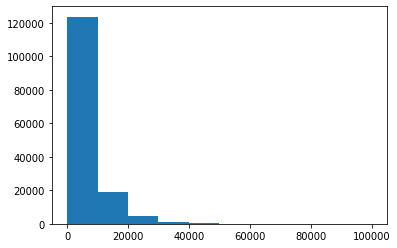

In [23]:
## 绘制标签的统计图，查看标签分布
plt.hist(Y_data)
plt.show()
plt.close()


### Step 4:数据建模

#### 1) 利用xgb进行五折交叉验证查看模型的参数效果

In [115]:
## xgb-Model
xgr = xgb.XGBRegressor(n_estimators=120, learning_rate=0.1, gamma=0, subsample=0.8,\
        colsample_bytree=0.9, max_depth=7) #,objective ='reg:squarederror'

scores_train = []
scores = []

## 5折交叉验证方式
sk=StratifiedKFold(n_splits=5,shuffle=True,random_state=0)
k = 1
for train_ind,val_ind in sk.split(X_data,Y_data):
    print('fold {}/5......'.format(k))
    train_x=X_data.iloc[train_ind].values
    train_y=Y_data.iloc[train_ind]
    val_x=X_data.iloc[val_ind].values
    val_y=Y_data.iloc[val_ind]
    
    xgr.fit(train_x,train_y)
    pred_train_xgb=xgr.predict(train_x)
    pred_xgb=xgr.predict(val_x)
    
    score_train = mean_absolute_error(train_y,pred_train_xgb)
    print('Train mae:',score_train)
    scores_train.append(score_train)
    score = mean_absolute_error(val_y,pred_xgb)
    scores.append(score)
    print('Val mae',score)
    k += 1
print('=========================')
print('Train mae:',np.mean(score_train))
print('Val mae',np.mean(scores))

fold 1/5......
Train mae: 541.104440483049
Val mae 617.1101099600475
fold 2/5......
Train mae: 535.6103858685037
Val mae 615.6748229052614
fold 3/5......
Train mae: 537.3373207313247
Val mae 618.7743412372903
fold 4/5......
Train mae: 540.6438487700785
Val mae 618.136991421187
fold 5/5......
Train mae: 534.844788560353
Val mae 619.3890811931876
Train mae: 534.844788560353
Val mae 617.8170693433947


#### 2） 定义xgb和lgb模型函数

In [27]:
def build_model_xgb(x_train,y_train):
    model = xgb.XGBRegressor(n_estimators=150, learning_rate=0.1, gamma=0, subsample=0.8,\
        colsample_bytree=0.9, max_depth=7) #, objective ='reg:squarederror'
    model.fit(x_train, y_train)
    return model

def build_model_lgb(x_train,y_train):
    estimator = lgb.LGBMRegressor(num_leaves=127,n_estimators = 150)
    param_grid = {
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
    }
    gbm = GridSearchCV(estimator, param_grid)
    gbm.fit(x_train, y_train)
    return gbm

def build_model_lgb2(x_train,y_train):
    gbm = lgb.LGBMRegressor(
        n_estimators=10000,
        learning_rate=0.01,
        boosting_type= 'gbdt',
        objective = 'regression_l1',
        max_depth = -1,
        num_leaves=31,
        min_child_samples = 20,
        feature_fraction = 0.8,
        bagging_freq = 1,
        bagging_fraction = 0.8,
        lambda_l2 = 2,
        random_state=2020,
        metric='mae'
    )
    gbm.fit(x_train, y_train)
    return gbm

def build_model_lgb3(x_train,y_train):
    gbm = lgb.LGBMRegressor(
        n_estimators=10000,
        num_leaves=31,
        boosting_type= 'gbdt',
        min_data_in_leaf=1,
        min_child_samples=20,
        objective='regression_l1',
        max_depth = -1,
        learning_rate=0.01,
        boosting='gbdt',
        feature_fraction=0.8,
        bagging_freq=1,
        bagging_fraction=0.8,
        bagging_seed=23,
        lambda_l2 = 2,
        metric='mae',
        lambda_l1=0.2,
        random_state=2020,
        nthread=4)
    gbm.fit(x_train, y_train)
    return gbm

def build_model_lgb4(x_train,y_train):
    gbm = lgb.LGBMRegressor(
        n_estimators=60000,
        learning_rate=0.01,
        boosting_type= 'gbdt',
        objective = 'regression_l1',
        max_depth = -1,
        num_leaves=31,
        min_child_samples = 20,
        feature_fraction = 0.8,
        bagging_freq = 1,
        bagging_fraction = 0.8,
        lambda_l2 = 2,
        random_state=2020,
        metric='mae'
    )
    gbm.fit(x_train, y_train)
    return gbm

#### 3）切分数据集（Train,Val）进行模型训练，评价和预测

In [25]:
## Split data with val
x_train,x_val,y_train,y_val = train_test_split(X_data,Y_data,test_size=0.3)

In [98]:
params = {
    'n_estimators': 10000, 
    'learning_rate': 0.01, 

    'boosting_type': 'gbdt', 
    'objective': 'regression_l1', 
    'max_depth': -1,
    'num_leaves': 31,

    'min_child_samples': 20, 
    'feature_fraction':  0.8, 
    'bagging_freq': 1, 
    'bagging_fraction': 0.8, 
    'lambda_l2': 2, 
    'random_state': 2020, 
    'metric': 'mae'
    }

data_train = lgb.Dataset(x_train, y_train, silent=True)
cv_results = lgb.cv(
    params, data_train, num_boost_round=10000, nfold=5, stratified=False, shuffle=True, metrics='mae',
    early_stopping_rounds=50, verbose_eval=100, show_stdv=True)
# print(cv_results)
print('best n_estimators:', len(cv_results['l1-mean']))
print('best cv score:', cv_results['l1-mean'][-1])

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5680
[LightGBM] [Info] Number of data points in the train set: 83460, number of used features: 338
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5680
[LightGBM] [Info] Number of data points in the train set: 83460, number of used features: 338
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5680
[LightGBM] [Info] Number of data points in the train set: 83460, number of used features: 338
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007162 seconds.
You can set `f

In [28]:
print('Train lgb...')
model_lgb = build_model_lgb4(x_train,y_train)
val_lgb = model_lgb.predict(x_val)
# val_lgb = np.expm1(model_lgb.predict(x_val))

MAE_lgb = mean_absolute_error(y_val,val_lgb)
print('MAE of val with lgb:',MAE_lgb)

print('Predict lgb...')
model_lgb_pre = build_model_lgb4(X_data,Y_data)
subA_lgb = model_lgb_pre.predict(X_test)
# subA_lgb = np.expm1(model_lgb_pre.predict(X_test))
print('Sta of Predict lgb:')
Sta_inf(subA_lgb)

result_lgb = pd.DataFrame()
result_lgb['SaleID'] = TestA_data.SaleID
result_lgb['price'] = subA_lgb
result_lgb.to_csv('./result_lgb.csv',index=False)

Train lgb...
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
MAE of val with lgb: 484.6448669816929
Predict lgb...
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Sta of Predict lgb:
_min -639.12730

In [502]:
print('Train xgb...')
model_xgb = build_model_xgb(x_train,y_train)
val_xgb = model_xgb.predict(x_val)
MAE_xgb = mean_absolute_error(y_val,val_xgb)
print('MAE of val with xgb:',MAE_xgb)

print('Predict xgb...')
model_xgb_pre = build_model_xgb(X_data,Y_data)
subA_xgb = model_xgb_pre.predict(X_test)
print('Sta of Predict xgb:')
Sta_inf(subA_xgb)

result_xgb = pd.DataFrame()
result_xgb['SaleID'] = TestA_data.SaleID
result_xgb['price'] = subA_xgb
result_xgb.to_csv('./result_xgb.csv',index=False)

Train xgb...
MAE of val with xgb: 611.3530994280866
Predict xgb...
Sta of Predict xgb:
_min -888.506
_max: 86192.71
_mean 5901.3467
_ptp 87081.22
_std 7274.112
_var 52912704.0


#### 4）进行两模型的结果加权融合

In [ ]:
## 这里我们采取了简单的加权融合的方式
val_Weighted = (1-MAE_lgb/(MAE_xgb+MAE_lgb))*val_lgb+(1-MAE_xgb/(MAE_xgb+MAE_lgb))*val_xgb
val_Weighted[val_Weighted<0]=10 # 由于我们发现预测的最小值有负数，而真实情况下，price为负是不存在的，由此我们进行对应的后修正
print('MAE of val with Weighted ensemble:',mean_absolute_error(y_val,val_Weighted))

In [ ]:
sub_Weighted = (1-MAE_lgb/(MAE_xgb+MAE_lgb))*subA_lgb+(1-MAE_xgb/(MAE_xgb+MAE_lgb))*subA_xgb

## 查看预测值的统计情况
plt.hist(sub_Weighted)
plt.show()
plt.close()

#### 5）输出结果

In [ ]:
sub = pd.DataFrame()
sub['SaleID'] = TestA_data.SaleID
sub['price'] = sub_Weighted
sub.to_csv('./sub_Weighted.csv',index=False)

In [ ]:
sub.head()